# ML Binary Classification Tumor Type

This notebook 

Data Source: https://www.kaggle.com/datasets/erdemtaha/cancer-data

In [57]:
# Data Preparation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing

# Modelling
np.random.seed(42)
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Hypertuning
from scipy.stats import pearsonr
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("data/Cancer_Data.csv")
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

The dataset is a 569x33 table. The 33 columns comprise of id (tumor id), diagnosis (classification label), 30 characteristics of the tumor, and an "Unnamed" column that is entirely null. The id and Unnamed columns will be dropped to result in a 569x30 table. All features are floating values and thus do not need to be made numerical. No other datapoints need to be dropped or filled - data is fully preprocessed.

In [4]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [5]:
# New definition of df
df = df.drop(columns = ["id", "Unnamed: 32"])
df["diagnosis"] = df["diagnosis"].replace({"M": 1, "B": 0})

df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Further analysis

In [6]:
df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [7]:
def two_class_hist_plot(df):

    # Create subplots
    fig, ax = plt.subplots(ncols=2, nrows=15, figsize=(8,30), dpi=100)
    ax = ax.flatten()

    # Plot histograms with Gaussian curve for each column (excluding "diagnosis")
    for i, col in enumerate(df.drop(columns="diagnosis").columns):
        # Define data arrays
        malignant_data = df[df["diagnosis"] == 1][col]
        benign_data = df[df["diagnosis"] == 0][col]

        # Calculate common bin edges for the current column
        combined_data = np.concatenate([malignant_data, benign_data])
        bin_edges = np.histogram_bin_edges(combined_data, bins=20)

        # Plot histograms
        sns.histplot(malignant_data, color="salmon", label='Malignant', kde=True, ax=ax[i], bins=bin_edges)
        sns.histplot(benign_data, color="lightblue", label='Benign', kde=True, ax=ax[i], bins=bin_edges)
        ax[i].set(xlabel=col, ylabel="Frequency")

        # Calculate mean
        mean_malignant = malignant_data.mean()
        mean_benign = benign_data.mean() 

        # Draw vertical lines for mean and IQR outliers
        ax[i].axvline(mean_malignant, color='red', linestyle='dashed', linewidth=2, label='Mean (Malignant)')
        ax[i].axvline(mean_benign, color='blue', linestyle='dashed', linewidth=2, label='Mean (Benign)')

        # Legend
        ax[i].legend(fontsize=6)

    plt.tight_layout()
    plt.show()

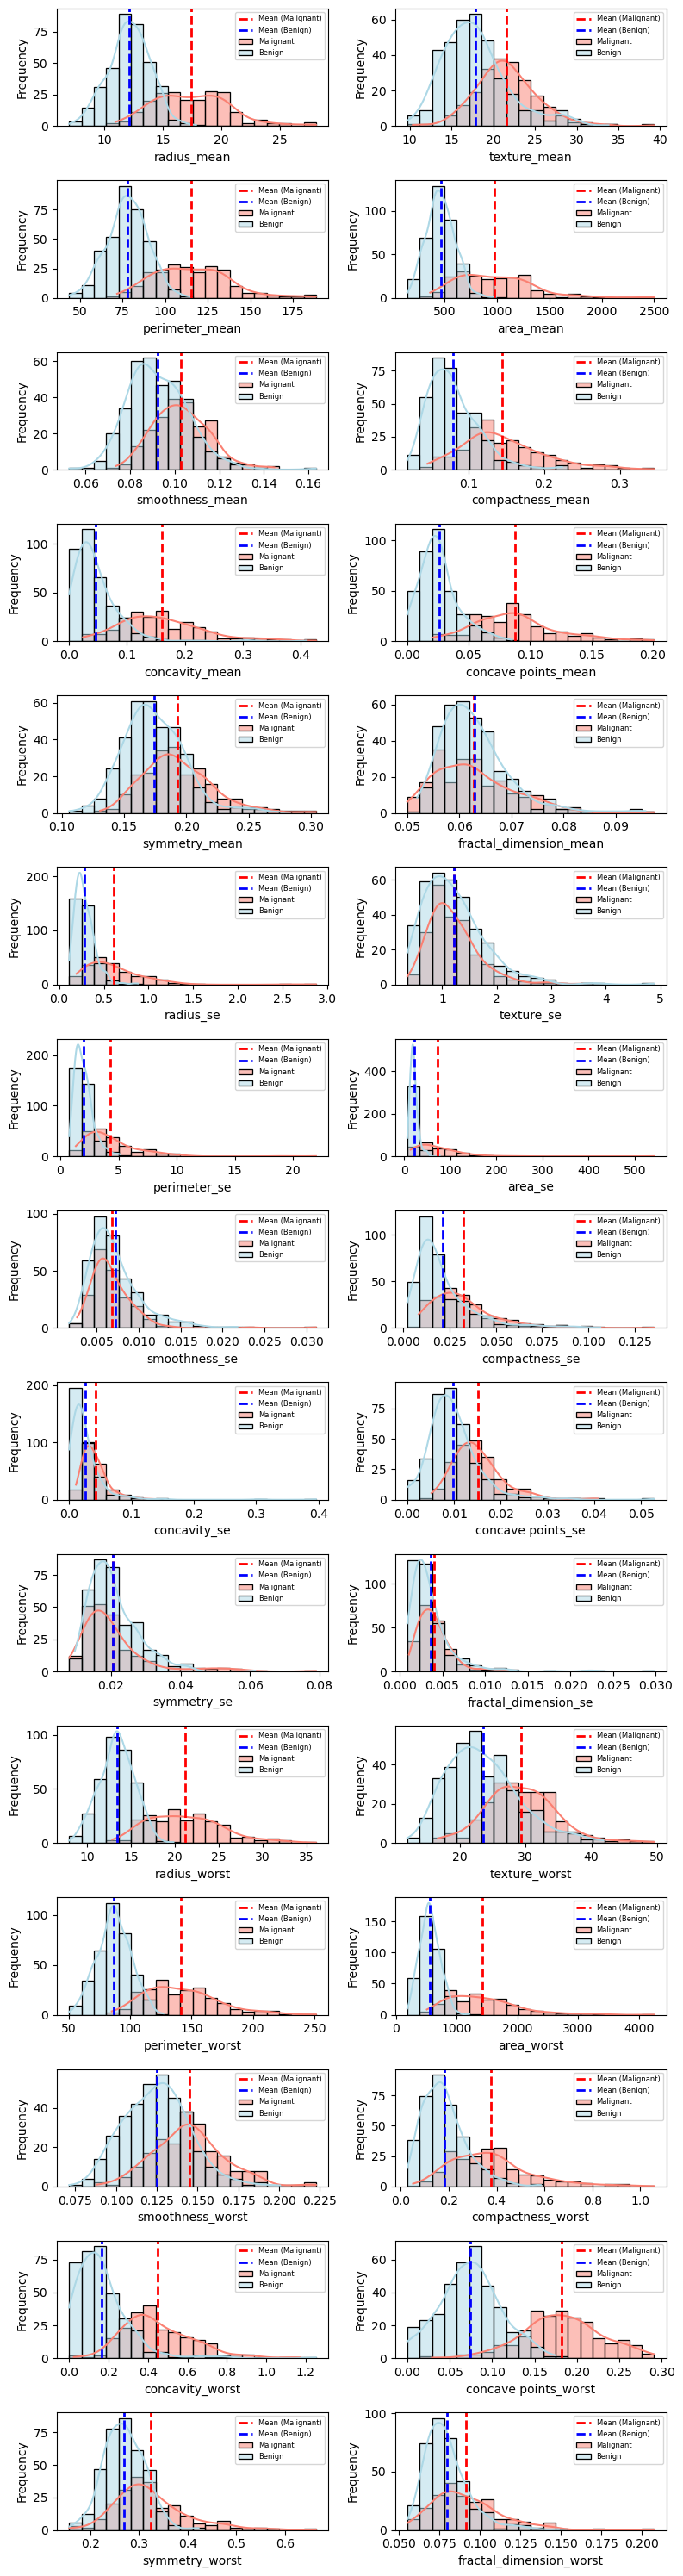

In [8]:
two_class_hist_plot(df)

Some characteristics such as concavity and worst radius appear to exhibit significant differences in distribution between malignant and benign tumors, whereas others such as fractal dimension and texture appear to be indistinguishable from one another. Outliers as defined by the IQR are present in the dataset; these will be kept for baseline but may need to be removed during model tuning. Statistically insignificant dataset and noncorrelative characteristics demonstrated by p-values of t-test and correlation coefficients also may need to be dropped from the dataset during model tuning.

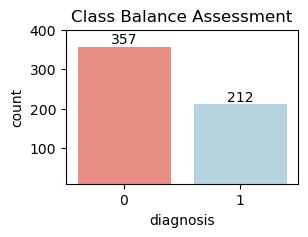

In [9]:
fig, ax = plt.subplots(figsize=(3, 2))
ax = sns.countplot(x="diagnosis", data=df, palette=["salmon","lightblue"])

for container in ax.containers:
    ax.bar_label(container)
    
ax.set(title="Class Balance Assessment", ylim=(10, 400))
plt.show()

In [10]:
minority_proportion = df[df["diagnosis"] == 1].count()[0]/len(df)
f"{minority_proportion:.3f}"

'0.373'

There is class imbalance with the benign tumor class making up only 37% of the entire dataset. During the model tuning process, the data may need to be resampled using SMOTE.

## Split Train and Test Data

In [11]:
from sklearn import preprocessing

# Define X and scale data to 0 mean
X = df.drop(columns = ["diagnosis"])

# Define y
y = df["diagnosis"]

# Split training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
print(X_train.shape)
print(y_train.shape)

(455, 30)
(455,)


## Baseline selection of models

In [13]:
# <100K samples
# recommend LinearSVC, KNeighbors Classifer by Scikit Learn
# also try RandomForestClassifier, LogisticRegression

# note: tried LinearSVC. prompted to increase interations due to failed convergence. 
#                        from 1,000 to 1,000,000 still no convergence. suggests to scale data to 0 mean using StandardScaler()
#                        no errors after scaling to 0 mean.
# note: tried KNeighbors. error showed that KNN does not have a score method. typically used for unsupervised learning. 
#                         will try sklearn.metrics.accuracy_score. error showed that KNN does not have predict method. 
#                         deleted "KNN": NearestNeighbors() from model dict

# from sklearn.svm import LinearSVC
# from sklearn.neighbors import NearestNeighbors // DELETED
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression

In [14]:
models = {
    "LinearSVC": LinearSVC(),
    "RandomForest": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression()
}

In [15]:
def evaluate_models(X, y, models):
    scoring_metrics = ["accuracy", "precision", "recall", "f1"]

    results = pd.DataFrame(index=scoring_metrics)

    for model_name, model in models.items():
        model_results = []

        print(f"Analysis for {model_name}")
        
        for scoring_metric in scoring_metrics:
            cross_val_score_array = cross_val_score(model, X, y, cv=5, scoring=scoring_metric)
            cross_val_score_mean = "{:.3f}".format(np.mean(cross_val_score_array))
            cross_val_score_std = "{:.3f}".format(np.std(cross_val_score_array))
            
            model_results.append([cross_val_score_mean, "+/-", cross_val_score_std])
            
        results[model_name] = model_results
           
    return results

In [16]:
results_df = evaluate_models(X_train, y_train, models)
print(results_df)

Analysis for LinearSVC


C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\

Analysis for RandomForest
Analysis for LogisticRegression


C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

                     LinearSVC         RandomForest   LogisticRegression
accuracy   [0.923, +/-, 0.043]  [0.956, +/-, 0.016]  [0.938, +/-, 0.031]
precision  [0.785, +/-, 0.234]  [0.947, +/-, 0.020]  [0.934, +/-, 0.049]
recall     [0.824, +/-, 0.116]  [0.935, +/-, 0.043]  [0.900, +/-, 0.048]
f1         [0.886, +/-, 0.073]  [0.939, +/-, 0.020]  [0.916, +/-, 0.041]


C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

LinearSVC and LogisticRegression are failing to converge at default parameters. Suggestion to scale the data.

## Scale Data for LinearSVC and LogisticRegression

In [32]:
# Define X and scale data to 0 mean
scaler_X = preprocessing.StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

# Scale X_test to 0 mean
X_test_scaled = pd.DataFrame(scaler_X.transform(X_test), columns=X_test.columns)

In [33]:
# Usable variables:
# X_scaled_df, y_train, X_test_scaled

In [34]:
print(X_train_scaled_df.shape)
print(y_train.shape)

(455, 30)
(455,)


In [36]:
# Create a DataFrame containing scaled X_train values
df_train_scaled = pd.concat([X_train_scaled_df, y_train], axis=1)
df_train_scaled

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
68,-1.440753,-0.435319,-1.362085,-1.139118,0.780573,0.718921,2.823135,-0.119150,1.092662,2.458173,...,-0.476309,-1.247920,-0.973968,0.722894,1.186732,4.672828,0.932012,2.097242,1.886450,0
181,1.974096,1.733026,2.091672,1.851973,1.319843,3.426275,2.013112,2.665032,2.127004,1.558396,...,1.311279,2.081617,2.137405,0.761928,3.265601,1.928621,2.698947,1.891161,2.497838,1
63,-1.399982,-1.249622,-1.345209,-1.109785,-1.332645,-0.307355,-0.365558,-0.696502,1.930333,0.954379,...,-1.040811,-1.245220,-0.999715,-1.438693,-0.548564,-0.644911,-0.970239,0.597602,0.057894,0
248,-0.981797,1.416222,-0.982587,-0.866944,0.059390,-0.596788,-0.820203,-0.845115,0.313264,0.074041,...,1.593530,-0.873572,-0.742947,0.796624,-0.729392,-0.774950,-0.809483,0.798928,-0.134497,0
60,-1.117700,-1.010259,-1.125002,-0.965942,1.269511,-0.439002,-0.983341,-0.930600,3.394436,0.950213,...,-1.334616,-1.117138,-0.896549,-0.174876,-0.995079,-1.209146,-1.354582,1.033544,-0.205732,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,-1.480675,-1.066580,-1.362085,-1.157451,0.149987,0.944057,-0.035754,-0.514485,0.331474,3.755073,...,-1.628421,-1.336108,-1.045037,-0.469795,-0.059039,-0.627221,-1.016366,-1.032028,1.376025,0
106,-0.701497,-0.200650,-0.687880,-0.682204,1.327033,-0.036619,-0.229252,-0.353247,-0.036372,0.339253,...,0.614731,-0.647704,-0.626555,1.616328,0.085623,0.060743,0.116740,-0.156974,0.398365,0
270,0.048802,-0.555001,-0.065125,-0.061423,-2.261627,-1.466613,-1.028567,-1.105515,-1.103492,-1.249242,...,-0.806427,-0.379841,-0.339278,-1.989065,-1.307006,-1.127968,-1.239034,-0.708639,-1.271455,0
435,-0.038969,0.102073,-0.031374,-0.154780,0.737432,0.184701,0.298585,0.430059,-0.517123,0.372579,...,0.868921,0.203878,-0.013556,1.291049,0.672020,0.632532,1.050012,0.434322,1.213362,1


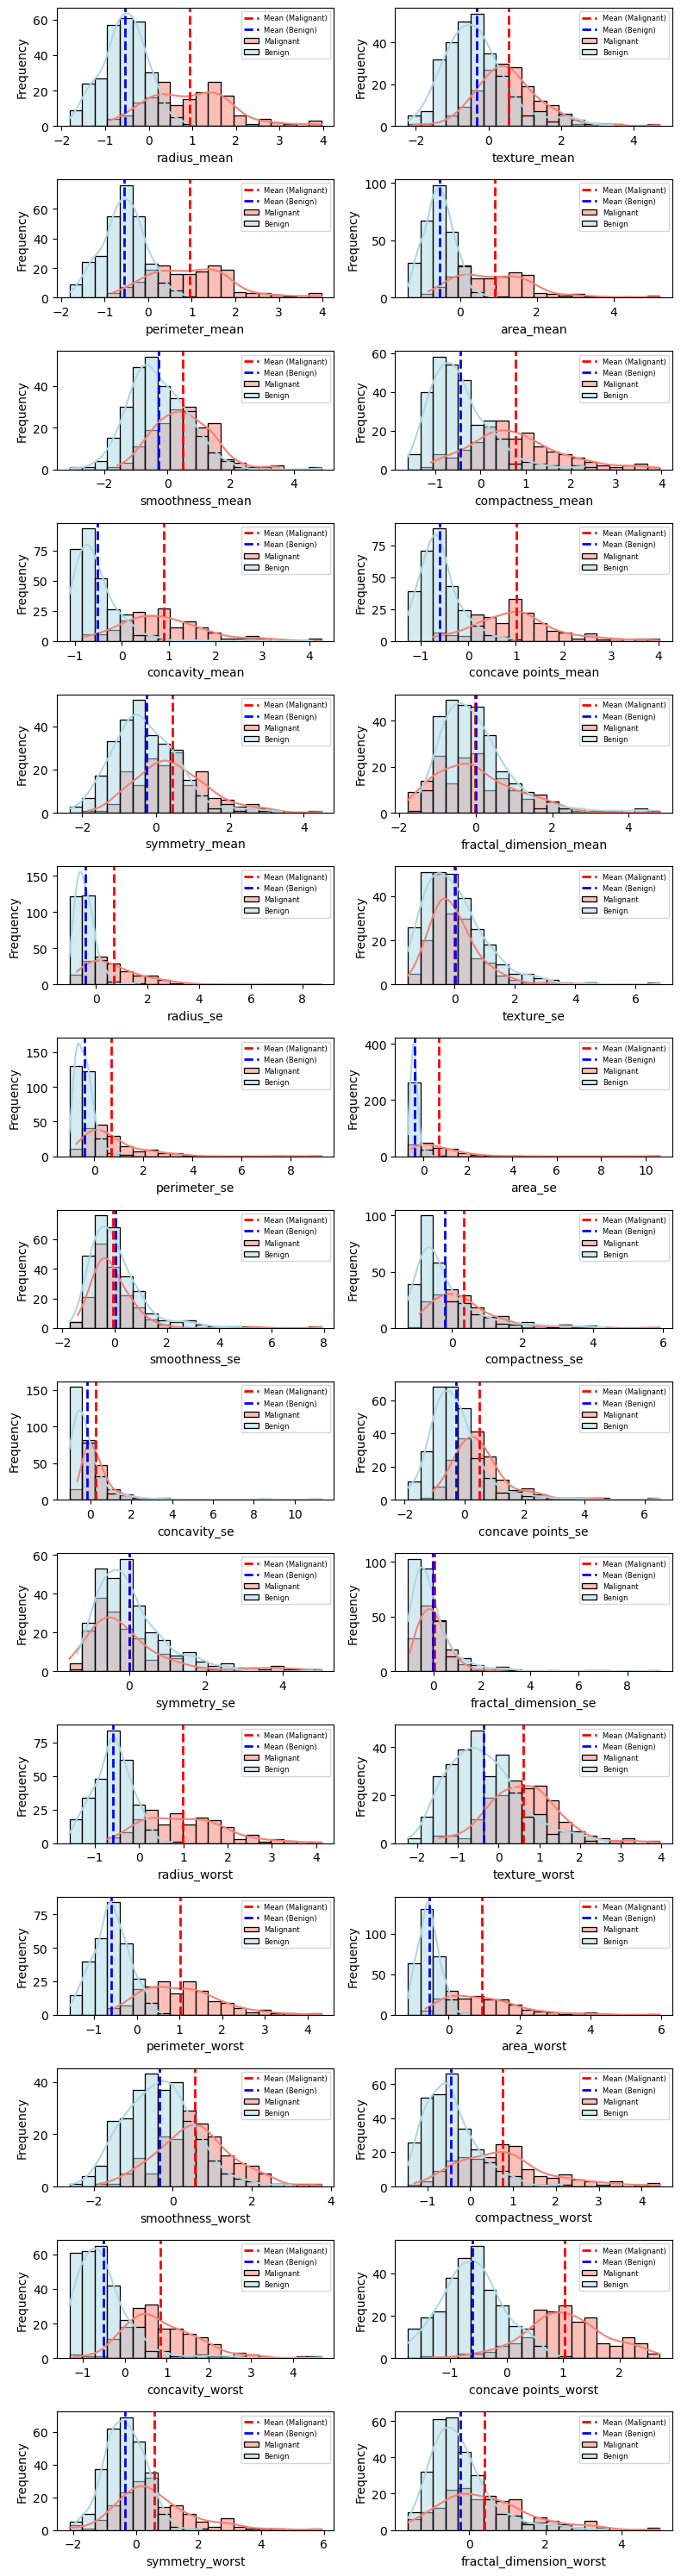

In [37]:
two_class_hist_plot(df_train_scaled)

In [38]:
results_df = evaluate_models(X_train_scaled_df, y_train, models)
print(results_df)

Analysis for LinearSVC
Analysis for RandomForest
Analysis for LogisticRegression
                     LinearSVC         RandomForest   LogisticRegression
accuracy   [0.971, +/-, 0.019]  [0.952, +/-, 0.025]  [0.974, +/-, 0.018]
precision  [0.976, +/-, 0.023]  [0.964, +/-, 0.021]  [0.976, +/-, 0.029]
recall     [0.947, +/-, 0.034]  [0.929, +/-, 0.044]  [0.953, +/-, 0.040]
f1         [0.961, +/-, 0.026]  [0.937, +/-, 0.016]  [0.964, +/-, 0.024]


Scaling the features resolved the convergence issue.

## SMOTE with Scaled X_train

In [39]:
smt = SMOTE()
X_train_res, y_train_res = smt.fit_resample(X_train_scaled_df, y_train)

print(f'Distribution BEFORE balancing:\n{y_train.value_counts()}')
print('=-'*16)
print(f'Distribution AFTER balancing:\n{y_train_res.value_counts()}')

#X_train_res
#y_train_res

Distribution BEFORE balancing:
0    286
1    169
Name: diagnosis, dtype: int64
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Distribution AFTER balancing:
0    286
1    286
Name: diagnosis, dtype: int64


In [41]:
results_df2 = evaluate_models(X_train_res, y_train_res, models)

Analysis for LinearSVC
Analysis for RandomForest
Analysis for LogisticRegression


In [42]:
print("Before SMOTE")
print(results_df)
print("After SMOTE")
print(results_df2)

Before SMOTE
                     LinearSVC         RandomForest   LogisticRegression
accuracy   [0.971, +/-, 0.019]  [0.952, +/-, 0.025]  [0.974, +/-, 0.018]
precision  [0.976, +/-, 0.023]  [0.964, +/-, 0.021]  [0.976, +/-, 0.029]
recall     [0.947, +/-, 0.034]  [0.929, +/-, 0.044]  [0.953, +/-, 0.040]
f1         [0.961, +/-, 0.026]  [0.937, +/-, 0.016]  [0.964, +/-, 0.024]
After SMOTE
                     LinearSVC         RandomForest   LogisticRegression
accuracy   [0.970, +/-, 0.018]  [0.965, +/-, 0.012]  [0.979, +/-, 0.010]
precision  [0.982, +/-, 0.011]  [0.955, +/-, 0.014]  [0.983, +/-, 0.015]
recall     [0.958, +/-, 0.032]  [0.972, +/-, 0.018]  [0.976, +/-, 0.018]
f1         [0.970, +/-, 0.018]  [0.965, +/-, 0.015]  [0.979, +/-, 0.011]


SMOTE does not appear to significantly improve the accuracy of these models. Therefore SMOTE will not be used for further training.

## Correlation Coefficients

Correlation coefficients are analyzed to potentially identify features that least contribute to the target results.

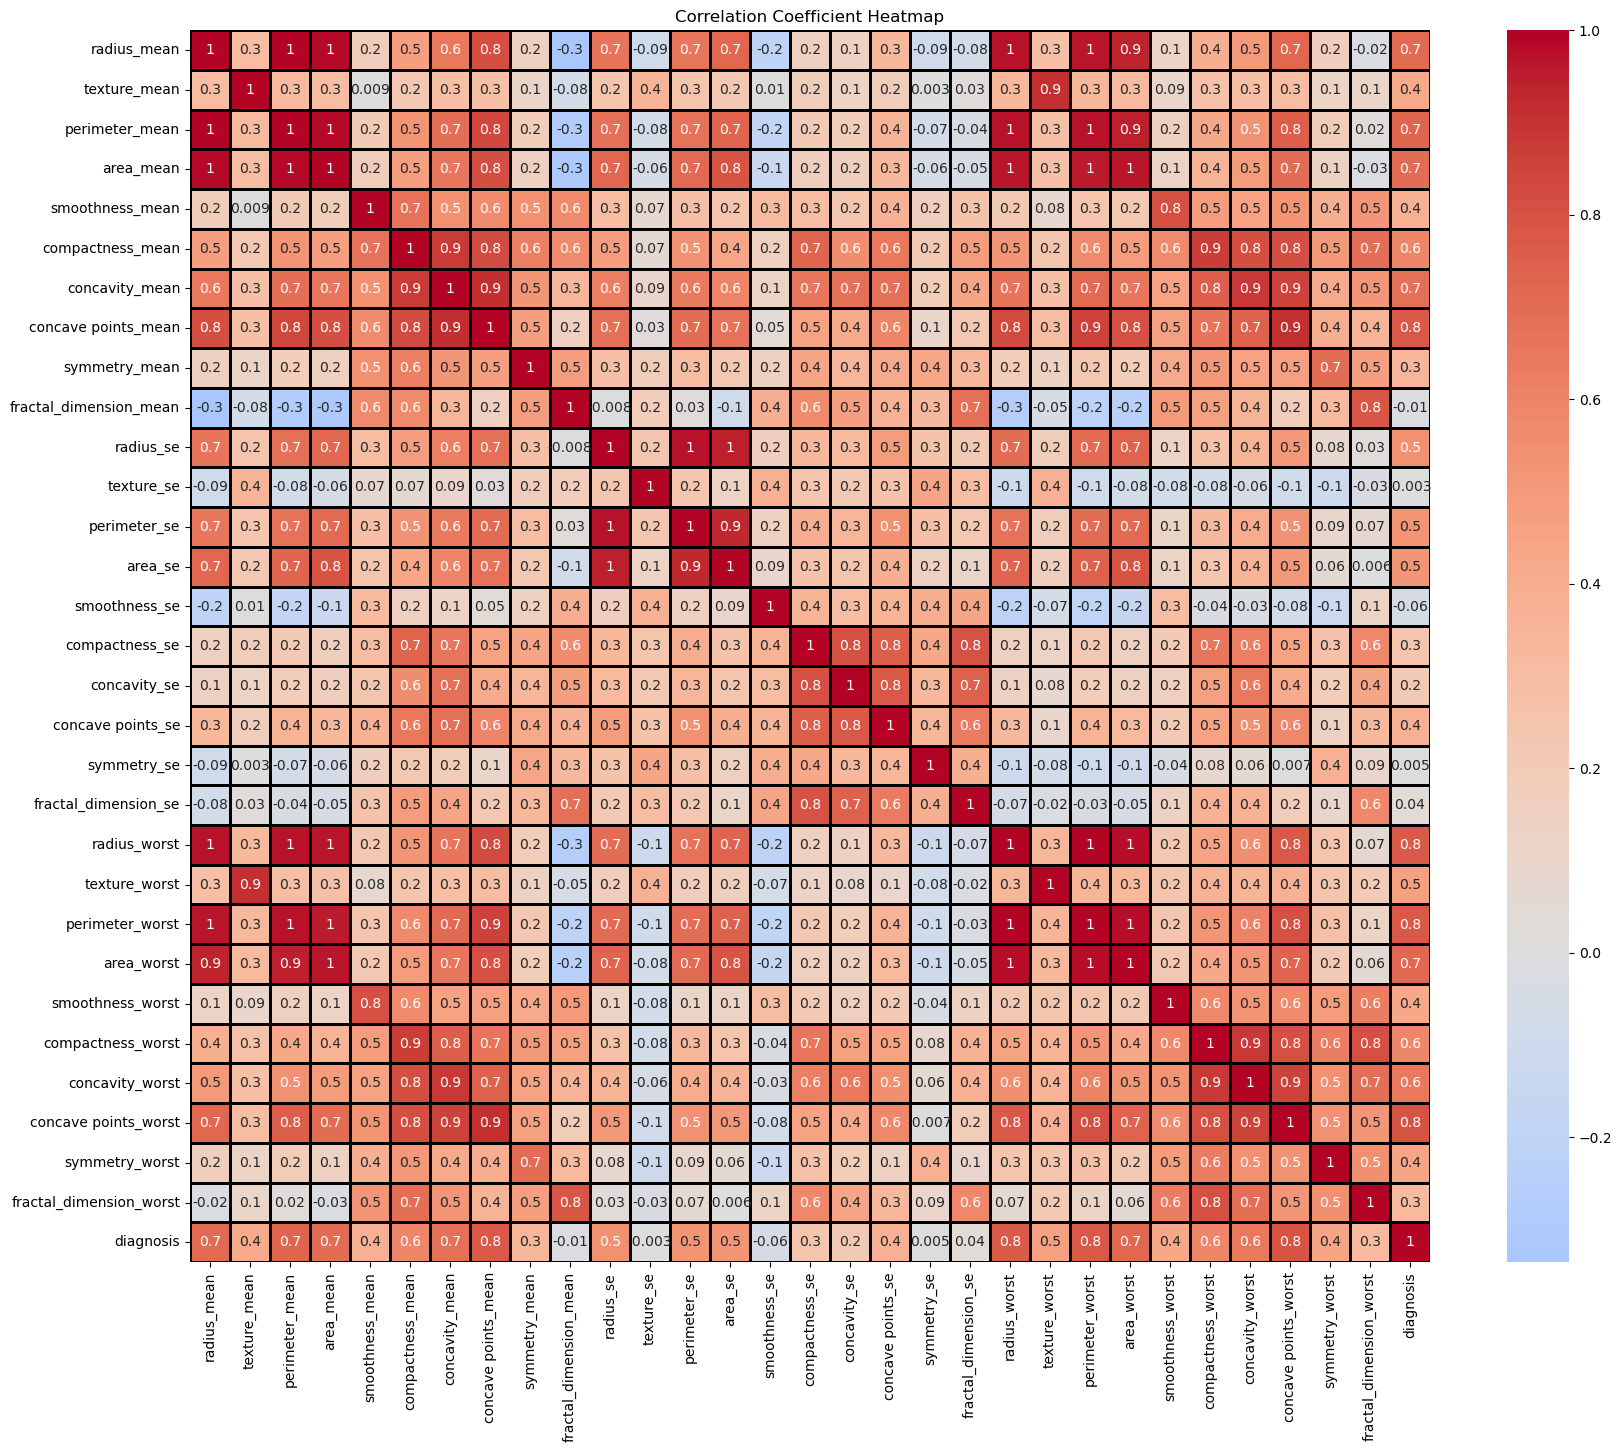

In [43]:
# Create a heatmap using Seaborn
plt.figure(figsize=(20, 16))
sns.heatmap(data = df_train_scaled.corr(),
            annot = True,
            fmt = '.1g',       #.1g (1 decimal)
            center = 0,        #0.7
            cmap = 'coolwarm',  #rocket
            linewidths = 1,
            linecolor = 'black')
plt.title("Correlation Coefficient Heatmap")
plt.show()

In [44]:
def optimize_corr(dataframe, X_input, y_input, models_input):
    coeff_values = np.arange(0, 1.1, 0.1)
    for coeff in coeff_values:
        columns_to_drop = dataframe.corr()["diagnosis"][dataframe.corr()["diagnosis"] < abs(coeff)].index
        X_train_filtered = X_input.drop(columns=columns_to_drop).values
        y_train_reshaped = y_input.values.ravel()  # Reshape y to a 1D array
        
        results_df = evaluate_models(X_train_filtered, y_train_reshaped, models_input)
        print(f"Coefficient: {coeff}")
        print(results_df)
        print("=" * 40)

In [45]:
optimize_corr(df_train_scaled, X_train_scaled_df, y_train, models)

Analysis for LinearSVC
Analysis for RandomForest
Analysis for LogisticRegression
Coefficient: 0.0
                     LinearSVC         RandomForest   LogisticRegression
accuracy   [0.974, +/-, 0.018]  [0.954, +/-, 0.018]  [0.974, +/-, 0.018]
precision  [0.976, +/-, 0.023]  [0.964, +/-, 0.021]  [0.976, +/-, 0.029]
recall     [0.953, +/-, 0.030]  [0.929, +/-, 0.044]  [0.953, +/-, 0.040]
f1         [0.964, +/-, 0.024]  [0.946, +/-, 0.021]  [0.964, +/-, 0.024]
Analysis for LinearSVC
Analysis for RandomForest
Analysis for LogisticRegression
Coefficient: 0.1
                     LinearSVC         RandomForest   LogisticRegression
accuracy   [0.971, +/-, 0.019]  [0.958, +/-, 0.023]  [0.976, +/-, 0.013]
precision  [0.966, +/-, 0.041]  [0.964, +/-, 0.021]  [0.977, +/-, 0.022]
recall     [0.959, +/-, 0.023]  [0.935, +/-, 0.039]  [0.959, +/-, 0.035]
f1         [0.962, +/-, 0.025]  [0.942, +/-, 0.025]  [0.967, +/-, 0.017]
Analysis for LinearSVC
Analysis for RandomForest
Analysis for LogisticRegr

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_classes.py", line 263, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\utils\validation.py", line 1106, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\utils\validation.py", line 940, in check_array
    raise ValueError(
ValueError: Found array with 0 feature(s) (shape=(364, 0)) while a minimum of 1 is required by LinearSVC.


Filtering out any number of features starting from the smallest correlation coefficient did yield significant improvements to accuracy. Therefore, all features will be kept during hyperparameter tuning.

## Hyperparameter Tuning using GridSearchCV

Hyperparameter tuning will be conducted on the LinearSVC and LogisticRegression which produced accuracy scores of 97%

In [46]:
LinearSVC().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [47]:
grid_svm = {"loss": ["hinge", "squared_hinge"], #default: sq_hinged
    "dual": [True, False],                  #default: True
    "C": [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],  #default: 1
    "penalty": ["l1", "l2"],                  #default: l2
    "tol": [1e-4, 1e-3],          #default: 1e-4
    "max_iter": [1000, 5000, 10000, 20000, 50000, 150000]} #default: 1000

gs_clf = GridSearchCV(estimator=LinearSVC(), 
                      param_grid=grid_svm,
                      cv = 5,
                      verbose = 2)

gs_clf.fit(X_train_scaled_df, y_train)
gs_clf.best_params_

Fitting 5 folds for each of 672 candidates, totalling 3360 fits
[CV] END C=0.0001, dual=True, loss=hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.0001, dual=True, loss=hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.0001, dual=True, loss=hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.0001, dual=True, loss=hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.0001, dual=True, loss=hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.0001, dual=True, loss=hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.0001, dual=True, loss=hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.0001, dual=True, loss=hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.0001, dual=True, loss=hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.0001, dual=True, loss=hinge

[CV] END C=0.0001, dual=True, loss=hinge, max_iter=150000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.0001, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.0001, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.0001, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.0001, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.0001, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.0001, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.0001, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.0001, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.0001, dual=True, loss=squ

[CV] END C=0.0001, dual=True, loss=squared_hinge, max_iter=150000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.0001, dual=True, loss=squared_hinge, max_iter=150000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.0001, dual=True, loss=squared_hinge, max_iter=150000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.0001, dual=False, loss=hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.0001, dual=False, loss=hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.0001, dual=False, loss=hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.0001, dual=False, loss=hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.0001, dual=False, loss=hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.0001, dual=False, loss=hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.0001, dual=False, loss=hinge, max_iter=1000, penalty=l1

[CV] END C=0.0001, dual=False, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.0001, dual=False, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.0001, dual=False, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.0001, dual=False, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.0001, dual=False, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.0001, dual=False, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.0001, dual=False, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.0001, dual=False, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.0001, dual=False, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.0001, dual=

[CV] END C=0.0001, dual=False, loss=squared_hinge, max_iter=150000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.0001, dual=False, loss=squared_hinge, max_iter=150000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.0001, dual=False, loss=squared_hinge, max_iter=150000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.0001, dual=False, loss=squared_hinge, max_iter=150000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.0001, dual=False, loss=squared_hinge, max_iter=150000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.0001, dual=False, loss=squared_hinge, max_iter=150000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.0001, dual=False, loss=squared_hinge, max_iter=150000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.0001, dual=False, loss=squared_hinge, max_iter=150000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.0001, dual=False, loss=squared_hinge, max_iter=150000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] E

[CV] END C=0.001, dual=True, loss=hinge, max_iter=50000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=50000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=50000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=50000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=150000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=150000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=150000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=150000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=150000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=150000, penalty=l1, tol=0.001; total time=   0.0s

[CV] END C=0.001, dual=False, loss=hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.001, dual=False, loss=hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.001, dual=False, loss=hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.001, dual=False, loss=hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.001, dual=False, loss=hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.001, dual=False, loss=hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.001, dual=False, loss=hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.001, dual=False, loss=hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.001, dual=False, loss=hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.001, dual=False, loss=hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] 

[CV] END C=0.001, dual=False, loss=hinge, max_iter=150000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.001, dual=False, loss=hinge, max_iter=150000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.001, dual=False, loss=hinge, max_iter=150000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.001, dual=False, loss=hinge, max_iter=150000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.001, dual=False, loss=hinge, max_iter=150000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.001, dual=False, loss=hinge, max_iter=150000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.001, dual=False, loss=hinge, max_iter=150000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.001, dual=False, loss=hinge, max_iter=150000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.001, dual=False, loss=hinge, max_iter=150000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.001, dual=False, loss=hinge, max_iter=150000, penalty=l2, tol=0.001; tota

[CV] END C=0.01, dual=True, loss=hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.01, dual=True, loss=hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.01, dual=True, loss=hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.01, dual=True, loss=hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.01, dual=True, loss=hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.01, dual=True, loss=hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.01, dual=True, loss=hinge, max_iter=5000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.01, dual=True, loss=hinge, max_iter=5000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.01, dual=True, loss=hinge, max_iter=5000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.01, dual=True, loss=hinge, max_iter=5000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.01, dual=Tru

[CV] END C=0.01, dual=True, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.01, dual=True, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.01, dual=True, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.01, dual=True, loss=squared_hinge, max_iter=10000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.01, dual=True, loss=squared_hinge, max_iter=10000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.01, dual=True, loss=squared_hinge, max_iter=10000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.01, dual=True, loss=squared_hinge, max_iter=10000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.01, dual=True, loss=squared_hinge, max_iter=10000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.01, dual=True, loss=squared_hinge, max_iter=10000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.01, dual=True, loss=squared_

[CV] END C=0.01, dual=False, loss=hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.01, dual=False, loss=hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.01, dual=False, loss=hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.01, dual=False, loss=hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.01, dual=False, loss=hinge, max_iter=5000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.01, dual=False, loss=hinge, max_iter=5000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.01, dual=False, loss=hinge, max_iter=5000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.01, dual=False, loss=hinge, max_iter=5000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.01, dual=False, loss=hinge, max_iter=5000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.01, dual=False, loss=hinge, max_iter=5000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.01

[CV] END C=0.01, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.01, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.01, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.01, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.01, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.01, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.01, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.01, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.01, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.01, dual=False, loss=squared

[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hin

[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=10000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=10000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=10000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=10000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=20000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=20000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=20000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=20000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=20000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max

[CV] END C=0.1, dual=False, loss=hinge, max_iter=5000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=hinge, max_iter=5000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=hinge, max_iter=5000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=hinge, max_iter=5000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=hinge, max_iter=5000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=hinge, max_iter=5000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=hinge, max_iter=5000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=hinge, max_iter=5000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=hinge, max_iter=5000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=hinge, max_iter=5000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.1, dual=Fals

[CV] END C=0.1, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=squared_hinge, max

[CV] END C=0.1, dual=False, loss=squared_hinge, max_iter=50000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=squared_hinge, max_iter=50000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=squared_hinge, max_iter=50000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=squared_hinge, max_iter=50000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=squared_hinge, max_iter=50000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=squared_hinge, max_iter=50000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=squared_hinge, max_iter=50000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=squared_hinge, max_iter=50000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=squared_hinge, max_iter=50000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=0.1, dual=False, loss=squared_h

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1, dual=True, loss=hinge, max_iter=5000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=1, dual=True, loss=hinge, max_iter=5000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=1, dual=True, loss=hinge, max_iter=5000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=1, dual=True, loss=hinge, max_iter=5000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=1, dual=True, loss=hinge, max_iter=5000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=1, dual=True, loss=hinge, max_iter=5000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=1, dual=True, loss=hinge, max_iter=5000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=1, dual=True, loss=hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=1, dual=True, loss=hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=1, dual=True, loss=hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=1, dual=True, loss=hinge, max_iter=10000,

[CV] END C=1, dual=True, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=1, dual=True, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=1, dual=True, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=1, dual=True, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=1, dual=True, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=1, dual=True, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=1, dual=True, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=1, dual=True, loss=squared_hinge, max_iter=10000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=1, dual=True, loss=squared_hinge, max_iter=10000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=1, dual=True, loss=squared_hinge, max_iter=10000, penalty=

[CV] END C=1, dual=False, loss=hinge, max_iter=50000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=1, dual=False, loss=hinge, max_iter=50000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=1, dual=False, loss=hinge, max_iter=150000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=1, dual=False, loss=hinge, max_iter=150000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=1, dual=False, loss=hinge, max_iter=150000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=1, dual=False, loss=hinge, max_iter=150000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=1, dual=False, loss=hinge, max_iter=150000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=1, dual=False, loss=hinge, max_iter=150000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=1, dual=False, loss=hinge, max_iter=150000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=1, dual=False, loss=hinge, max_iter=150000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=1, dual=False, l

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1, dual=False, loss=squared_hinge, max_iter=5000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=1, dual=False, loss=squared_hinge, max_iter=5000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=1, dual=False, loss=squared_hinge, max_iter=5000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=1, dual=False, loss=squared_hinge, max_iter=5000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=1, dual=False, loss=squared_hinge, max_iter=5000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=1, dual=False, loss=squared_hinge, max_iter=5000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=1, dual=False, loss=squared_hinge, max_iter=5000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=1, dual=False, loss=squared_hinge, max_iter=5000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=1, dual=False, loss=squared_hinge, max_iter=5000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=1, dual=False, loss=squared_hinge, max_iter=5000, penalty

[CV] END C=1, dual=False, loss=squared_hinge, max_iter=150000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=1, dual=False, loss=squared_hinge, max_iter=150000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=1, dual=False, loss=squared_hinge, max_iter=150000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=1, dual=False, loss=squared_hinge, max_iter=150000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=1, dual=False, loss=squared_hinge, max_iter=150000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=1, dual=False, loss=squared_hinge, max_iter=150000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=1, dual=False, loss=squared_hinge, max_iter=150000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=1, dual=False, loss=squared_hinge, max_iter=150000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=1, dual=False, loss=squared_hinge, max_iter=150000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=1, dual=False, loss=squared_hinge, max_

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\

[CV] END C=10, dual=True, loss=hinge, max_iter=5000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=10, dual=True, loss=hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=True, loss=hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=True, loss=hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=True, loss=hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=True, loss=hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=True, loss=hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=10, dual=True, loss=hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=10, dual=True, loss=hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=10, dual=True, loss=hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=10, dual=True, loss=hinge

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\

[CV] END C=10, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=10, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=10, dual=True, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=True, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=True, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=True, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=True, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=True, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=10, dual=True, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=10, dual=True, loss=squared_hinge, max_iter=10000,

[CV] END C=10, dual=False, loss=hinge, max_iter=5000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=10, dual=False, loss=hinge, max_iter=5000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=10, dual=False, loss=hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=False, loss=hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=False, loss=hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=False, loss=hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=False, loss=hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=False, loss=hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=10, dual=False, loss=hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=10, dual=False, loss=hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=10, dual=False, 

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\

[CV] END C=10, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=1000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=1000

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, dual=False, loss=squared_hinge, max_iter=5000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=5000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=5000, penalty=l1, tol=0.0001; total time=   0.0s


C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, dual=False, loss=squared_hinge, max_iter=5000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=5000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=5000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=5000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=5000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=5000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=5000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=5000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=5000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=5000

[CV] END C=10, dual=False, loss=squared_hinge, max_iter=150000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=150000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=150000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=150000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=150000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=150000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=150000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=150000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hinge, max_iter=150000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=10, dual=False, loss=squared_hi

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\

[CV] END C=100, dual=True, loss=hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=True, loss=hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=True, loss=hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=True, loss=hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=True, loss=hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=True, loss=hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=True, loss=hinge, max_iter=10000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=True, loss=hinge, max_iter=10000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=True, loss=hinge, max_iter=10000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=True, loss=hinge, max_iter=10000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=True

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=100, dual=True, loss=hinge, max_iter=20000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=True, loss=hinge, max_iter=20000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=True, loss=hinge, max_iter=20000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=True, loss=hinge, max_iter=20000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=100, dual=True, loss=hinge, max_iter=20000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=100, dual=True, loss=hinge, max_iter=20000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=100, dual=True, loss=hinge, max_iter=20000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=100, dual=True, loss=hinge, max_iter=20000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=100, dual=True, loss=hinge, max_iter=50000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=True, loss=hinge, max_iter=50000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=True

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\

[CV] END C=100, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max_it

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\

[CV] END C=100, dual=True, loss=squared_hinge, max_iter=20000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max_iter=20000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max_iter=20000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max_iter=20000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max_iter=20000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max_iter=20000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max_iter=20000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max_iter=20000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max_iter=20000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=100, dual=True, loss=squared_hinge, max_iter=50000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max_iter=50000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max_iter=50000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max_iter=50000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max_iter=50000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max_iter=50000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max_iter=50000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max_iter=50000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max_iter=50000, penalty=l2, tol=0.001; total time=   0.0s
[CV] END C=100, dual=True, loss=squared_hinge, max

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\

[CV] END C=100, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=1000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, ma

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=100, dual=False, loss=squared_hinge, max_iter=5000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=5000, penalty=l1, tol=0.0001; total time=   0.0s


C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=100, dual=False, loss=squared_hinge, max_iter=5000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=5000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=5000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=5000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=5000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=5000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=5000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=5000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=5000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=100, dual=False, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.1s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s


C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=100, dual=False, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.1s


C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=100, dual=False, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.1s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=10000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=10000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=10000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_h

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=100, dual=False, loss=squared_hinge, max_iter=20000, penalty=l1, tol=0.0001; total time=   0.3s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=20000, penalty=l1, tol=0.0001; total time=   0.1s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=20000, penalty=l1, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=20000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=20000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=20000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=20000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=20000, penalty=l1, tol=0.001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_hinge, max_iter=20000, penalty=l2, tol=0.0001; total time=   0.0s
[CV] END C=100, dual=False, loss=squared_h

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1680 fits failed out of a total of 3360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
420 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
                                           ^^^^^^^^^^^^^^^
  File "C:\Users\calvi\Desk

{'C': 0.01,
 'dual': True,
 'loss': 'hinge',
 'max_iter': 1000,
 'penalty': 'l2',
 'tol': 0.0001}

In [50]:
def evaluate_preds(y_true, y_preds):
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)

    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(precision, 2),
                   "f1": round(f1, 2)}

    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")

In [51]:
gs_y_preds = gs_clf.predict(X_test_scaled)
gs_metrics = evaluate_preds(y_test, gs_y_preds)

Acc: 98.25%
Precision: 1.00
Recall: 0.95
F1 score: 0.98


In [52]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [54]:
log_reg_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                'dual': [True, False],
                'max_iter': [100, 500, 1000, 2000],
                'penalty': ['none', 'elasticnet', 'l1', 'l2'],
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                'tol': [1e-4, 1e-3]}


gs_log_reg = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

gs_log_reg.fit(X_train_scaled_df, y_train)
gs_log_reg.best_params_

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits


C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logis

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_log

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been d

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logis

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been d

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been d

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logis

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_log

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_log

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_log

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been d

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_log

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logis

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logis

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been d

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.p

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_log

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logis

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been d

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logis

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logis

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_log

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.p

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_log

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_log

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_s

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_l

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_l

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logis

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_log

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_log

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_log

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logis

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_log

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logis

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_log

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_log

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_log

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been d

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been d

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logis

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_log

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.p

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_log

C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\calvi\Desktop\Coding\DataScience1\env\Lib\site-packages\sklearn\linear_model\_log

{'C': 0.1,
 'dual': True,
 'max_iter': 100,
 'penalty': 'l2',
 'solver': 'liblinear',
 'tol': 0.0001}

In [55]:
gs_y_preds = gs_log_reg.predict(X_test_scaled)
gs_metrics = evaluate_preds(y_test, gs_y_preds)

Acc: 99.12%
Precision: 1.00
Recall: 0.98
F1 score: 0.99


LogisticRegression yielded the higher accuracy score of 99% after hyperparameter tuning.

## Model Evaluation

In [75]:
print(classification_report(y_test, gs_y_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        71
           1       1.00      0.98      0.99        43

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



In [65]:
def plot_conf_mat(y_test, y_preds):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                         annot=True, # Annotate the boxes
                         cbar=False)
    plt.xlabel("Predicted label") # model preds
    plt.ylabel("True label") # true labels 
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

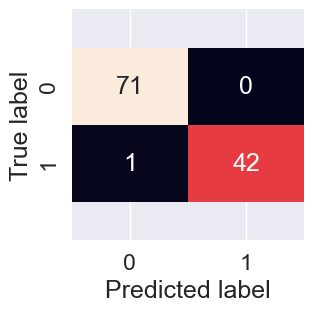

In [62]:
plot_conf_mat(y_test, gs_y_preds)

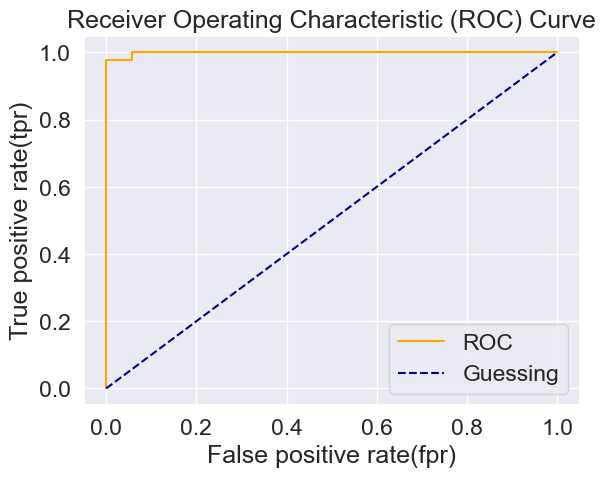

In [67]:
y_probs = gs_log_reg.predict_proba(X_test_scaled)
y_probs_positive = y_probs[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs_positive)

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color="orange", label="ROC")
    plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--", label="Guessing")
    plt.xlabel("False positive rate(fpr)")
    plt.ylabel("True positive rate(tpr)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()
    plt.show()

plot_roc_curve(fpr, tpr)

In [70]:
roc_auc_score(y_test, y_probs_positive)

0.998689813298395